# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=1,
        fold=2,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_10-29-38/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192008 [00:00<?, ?it/s]

  0%|          | 0/21405 [00:00<?, ?it/s]

  0%|          | 0/53239 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192008 [00:00<?, ?it/s]

  0%|          | 0/53239 [00:00<?, ?it/s]

  0%|          | 0/21405 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.4953 | MulticlassF1Score=0.2249
Batch-30 : CrossEntropyLoss=2.4936 | MulticlassF1Score=0.2426
Batch-45 : CrossEntropyLoss=2.4462 | MulticlassF1Score=0.2866
Batch-60 : CrossEntropyLoss=2.4014 | MulticlassF1Score=0.3435
Batch-75 : CrossEntropyLoss=2.3677 | MulticlassF1Score=0.3841
Batch-90 : CrossEntropyLoss=2.3773 | MulticlassF1Score=0.4193
Batch-105: CrossEntropyLoss=2.3650 | MulticlassF1Score=0.4455
Batch-120: CrossEntropyLoss=2.3746 | MulticlassF1Score=0.4663
Batch-135: CrossEntropyLoss=2.3363 | MulticlassF1Score=0.4877
Batch-150: CrossEntropyLoss=2.3559 | MulticlassF1Score=0.5064
Batch-165: CrossEntropyLoss=2.3471 | MulticlassF1Score=0.5211
Batch-180: CrossEntropyLoss=2.3337 | MulticlassF1Score=0.5332
Batch-195: CrossEntropyLoss=2.3451 | MulticlassF1Score=0.5447
Batch-210: CrossEntropyLoss=2.3503 | MulticlassF1Score=0.5535
Batch-225: CrossEntropyLoss=2.3629 | MulticlassF1Score=0.5615
Batch-226: CrossEntropyLoss=2.3720 | MulticlassF1Score=0.5618

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3472 | MulticlassF1Score=0.6861
Batch-30 : CrossEntropyLoss=2.3455 | MulticlassF1Score=0.6841
Batch-45 : CrossEntropyLoss=2.3613 | MulticlassF1Score=0.6806
Batch-60 : CrossEntropyLoss=2.3597 | MulticlassF1Score=0.6793
Batch-63 : CrossEntropyLoss=2.3672 | MulticlassF1Score=0.6779

Training   : Mean CrossEntropyLoss = 2.3985 | Mean MulticlassF1Score = 0.4245
Validation : Mean CrossEntropyLoss = 2.3481 | Mean MulticlassF1Score = 0.6826

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3434 | MulticlassF1Score=0.6777
Batch-30 : CrossEntropyLoss=2.3596 | MulticlassF1Score=0.6824
Batch-45 : CrossEntropyLoss=2.3539 | MulticlassF1Score=0.6871
Batch-60 : CrossEntropyLoss=2.3412 | MulticlassF1Score=0.6955
Batch-75 : CrossEntropyLoss=2.3339 | MulticlassF1Score=0.7000
Batch-90 : CrossEntropyLoss=2.3293 | MulticlassF1Score=0.7058
Batch-105: CrossEntropyLoss=2.3266 | MulticlassF1Score=0.7129
Batch-120: CrossEntropyLoss=2.3262 | MulticlassF1Score=0.7181
Batch-135: CrossEntropyLoss=2.3147 | MulticlassF1Score=0.7245
Batch-150: CrossEntropyLoss=2.3220 | MulticlassF1Score=0.7304
Batch-165: CrossEntropyLoss=2.3182 | MulticlassF1Score=0.7359
Batch-180: CrossEntropyLoss=2.3017 | MulticlassF1Score=0.7411
Batch-195: CrossEntropyLoss=2.3050 | MulticlassF1Score=0.7450
Batch-210: CrossEntropyLoss=2.3099 | MulticlassF1Score=0.7478
Batch-225: CrossEntropyLoss=2.3030 | MulticlassF1Score=0.7507
Batch-226: CrossEntropyLoss=2.3125 | MulticlassF1Score=0.7510

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3193 | MulticlassF1Score=0.7965
Batch-30 : CrossEntropyLoss=2.3140 | MulticlassF1Score=0.7920
Batch-45 : CrossEntropyLoss=2.3143 | MulticlassF1Score=0.7886
Batch-60 : CrossEntropyLoss=2.3118 | MulticlassF1Score=0.7914
Batch-63 : CrossEntropyLoss=2.3168 | MulticlassF1Score=0.7916

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3259 | Mean MulticlassF1Score = 0.7151
Validation : Mean CrossEntropyLoss = 2.3128 | Mean MulticlassF1Score = 0.7923

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3105 | MulticlassF1Score=0.7960
Batch-30 : CrossEntropyLoss=2.3122 | MulticlassF1Score=0.7963
Batch-45 : CrossEntropyLoss=2.3235 | MulticlassF1Score=0.7937
Batch-60 : CrossEntropyLoss=2.3183 | MulticlassF1Score=0.7931
Batch-75 : CrossEntropyLoss=2.3118 | MulticlassF1Score=0.7937
Batch-90 : CrossEntropyLoss=2.3029 | MulticlassF1Score=0.7942
Batch-105: CrossEntropyLoss=2.3105 | MulticlassF1Score=0.7959
Batch-120: CrossEntropyLoss=2.3087 | MulticlassF1Score=0.7975
Batch-135: CrossEntropyLoss=2.2987 | MulticlassF1Score=0.7982
Batch-150: CrossEntropyLoss=2.3100 | MulticlassF1Score=0.7985
Batch-165: CrossEntropyLoss=2.3043 | MulticlassF1Score=0.7995
Batch-180: CrossEntropyLoss=2.3152 | MulticlassF1Score=0.7995
Batch-195: CrossEntropyLoss=2.3034 | MulticlassF1Score=0.8003
Batch-210: CrossEntropyLoss=2.3085 | MulticlassF1Score=0.8007
Batch-225: CrossEntropyLoss=2.3080 | MulticlassF1Score=0.8009
Batch-226: CrossEntropyLoss=2.3235 | MulticlassF1Score=0.8008

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3142 | MulticlassF1Score=0.8068
Batch-30 : CrossEntropyLoss=2.2987 | MulticlassF1Score=0.8082
Batch-45 : CrossEntropyLoss=2.3123 | MulticlassF1Score=0.8059
Batch-60 : CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8073
Batch-63 : CrossEntropyLoss=2.3062 | MulticlassF1Score=0.8074

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3099 | Mean MulticlassF1Score = 0.7967
Validation : Mean CrossEntropyLoss = 2.3075 | Mean MulticlassF1Score = 0.8079

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3101 | MulticlassF1Score=0.8128
Batch-30 : CrossEntropyLoss=2.3123 | MulticlassF1Score=0.8118
Batch-45 : CrossEntropyLoss=2.3020 | MulticlassF1Score=0.8114
Batch-60 : CrossEntropyLoss=2.3013 | MulticlassF1Score=0.8161
Batch-75 : CrossEntropyLoss=2.3021 | MulticlassF1Score=0.8187
Batch-90 : CrossEntropyLoss=2.2979 | MulticlassF1Score=0.8196
Batch-105: CrossEntropyLoss=2.3043 | MulticlassF1Score=0.8202
Batch-120: CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8206
Batch-135: CrossEntropyLoss=2.3024 | MulticlassF1Score=0.8220
Batch-150: CrossEntropyLoss=2.3016 | MulticlassF1Score=0.8232
Batch-165: CrossEntropyLoss=2.3067 | MulticlassF1Score=0.8245
Batch-180: CrossEntropyLoss=2.3134 | MulticlassF1Score=0.8260
Batch-195: CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8266
Batch-210: CrossEntropyLoss=2.2985 | MulticlassF1Score=0.8276
Batch-225: CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8284
Batch-226: CrossEntropyLoss=2.2921 | MulticlassF1Score=0.8286

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2993 | MulticlassF1Score=0.8360
Batch-30 : CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8326
Batch-45 : CrossEntropyLoss=2.2973 | MulticlassF1Score=0.8348
Batch-60 : CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8355
Batch-63 : CrossEntropyLoss=2.3020 | MulticlassF1Score=0.8360

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3011 | Mean MulticlassF1Score = 0.8203
Validation : Mean CrossEntropyLoss = 2.2986 | Mean MulticlassF1Score = 0.8362

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2914 | MulticlassF1Score=0.8409
Batch-30 : CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8408
Batch-45 : CrossEntropyLoss=2.2984 | MulticlassF1Score=0.8422
Batch-60 : CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8396
Batch-75 : CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8396
Batch-90 : CrossEntropyLoss=2.3106 | MulticlassF1Score=0.8393
Batch-105: CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8386
Batch-120: CrossEntropyLoss=2.3058 | MulticlassF1Score=0.8390
Batch-135: CrossEntropyLoss=2.2973 | MulticlassF1Score=0.8394
Batch-150: CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8387
Batch-165: CrossEntropyLoss=2.3000 | MulticlassF1Score=0.8391
Batch-180: CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8395
Batch-195: CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8399
Batch-210: CrossEntropyLoss=2.3021 | MulticlassF1Score=0.8398
Batch-225: CrossEntropyLoss=2.3109 | MulticlassF1Score=0.8397
Batch-226: CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8396

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3007 | MulticlassF1Score=0.8359
Batch-30 : CrossEntropyLoss=2.3056 | MulticlassF1Score=0.8386
Batch-45 : CrossEntropyLoss=2.2932 | MulticlassF1Score=0.8377
Batch-60 : CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8372
Batch-63 : CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8376

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2975 | Mean MulticlassF1Score = 0.8397
Validation : Mean CrossEntropyLoss = 2.2980 | Mean MulticlassF1Score = 0.8363

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8419
Batch-30 : CrossEntropyLoss=2.2928 | MulticlassF1Score=0.8444
Batch-45 : CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8438
Batch-60 : CrossEntropyLoss=2.3038 | MulticlassF1Score=0.8430
Batch-75 : CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8418
Batch-90 : CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8427
Batch-105: CrossEntropyLoss=2.3062 | MulticlassF1Score=0.8415
Batch-120: CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8411
Batch-135: CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8407
Batch-150: CrossEntropyLoss=2.3064 | MulticlassF1Score=0.8407
Batch-165: CrossEntropyLoss=2.3012 | MulticlassF1Score=0.8407
Batch-180: CrossEntropyLoss=2.2915 | MulticlassF1Score=0.8413
Batch-195: CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8415
Batch-210: CrossEntropyLoss=2.2931 | MulticlassF1Score=0.8414
Batch-225: CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8415
Batch-226: CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8415

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8446
Batch-30 : CrossEntropyLoss=2.3026 | MulticlassF1Score=0.8404
Batch-45 : CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8397
Batch-60 : CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8394
Batch-63 : CrossEntropyLoss=2.3093 | MulticlassF1Score=0.8381

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2968 | Mean MulticlassF1Score = 0.8416
Validation : Mean CrossEntropyLoss = 2.2977 | Mean MulticlassF1Score = 0.8399

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8384
Batch-30 : CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8429
Batch-45 : CrossEntropyLoss=2.2974 | MulticlassF1Score=0.8490
Batch-60 : CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8510
Batch-75 : CrossEntropyLoss=2.2924 | MulticlassF1Score=0.8515
Batch-90 : CrossEntropyLoss=2.2985 | MulticlassF1Score=0.8528
Batch-105: CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8537
Batch-120: CrossEntropyLoss=2.2918 | MulticlassF1Score=0.8551
Batch-135: CrossEntropyLoss=2.3055 | MulticlassF1Score=0.8557
Batch-150: CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8563
Batch-165: CrossEntropyLoss=2.2946 | MulticlassF1Score=0.8566
Batch-180: CrossEntropyLoss=2.2971 | MulticlassF1Score=0.8570
Batch-195: CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8568
Batch-210: CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8569
Batch-225: CrossEntropyLoss=2.3037 | MulticlassF1Score=0.8565
Batch-226: CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8565

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8575
Batch-30 : CrossEntropyLoss=2.2897 | MulticlassF1Score=0.8565
Batch-45 : CrossEntropyLoss=2.3095 | MulticlassF1Score=0.8544
Batch-60 : CrossEntropyLoss=2.2909 | MulticlassF1Score=0.8547
Batch-63 : CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8547

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2924 | Mean MulticlassF1Score = 0.8520
Validation : Mean CrossEntropyLoss = 2.2927 | Mean MulticlassF1Score = 0.8554

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8597
Batch-30 : CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8612
Batch-45 : CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8603
Batch-60 : CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8579
Batch-75 : CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8587
Batch-90 : CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8592
Batch-105: CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8590
Batch-120: CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8593
Batch-135: CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8595
Batch-150: CrossEntropyLoss=2.2908 | MulticlassF1Score=0.8599
Batch-165: CrossEntropyLoss=2.2918 | MulticlassF1Score=0.8599
Batch-180: CrossEntropyLoss=2.2927 | MulticlassF1Score=0.8602
Batch-195: CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8603
Batch-210: CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8603
Batch-225: CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8601
Batch-226: CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8602

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8544
Batch-30 : CrossEntropyLoss=2.2921 | MulticlassF1Score=0.8532
Batch-45 : CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8550
Batch-60 : CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8543
Batch-63 : CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8549

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2911 | Mean MulticlassF1Score = 0.8596
Validation : Mean CrossEntropyLoss = 2.2925 | Mean MulticlassF1Score = 0.8544

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8597
Batch-30 : CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8587
Batch-45 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8591
Batch-60 : CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8597
Batch-75 : CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8596
Batch-90 : CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8594
Batch-105: CrossEntropyLoss=2.2921 | MulticlassF1Score=0.8596
Batch-120: CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8597
Batch-135: CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8597
Batch-150: CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8603
Batch-165: CrossEntropyLoss=2.3013 | MulticlassF1Score=0.8602
Batch-180: CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8616
Batch-195: CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8637
Batch-210: CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8651
Batch-225: CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8667
Batch-226: CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8668

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8829
Batch-30 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.8817
Batch-45 : CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8824
Batch-60 : CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8805
Batch-63 : CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8805

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2890 | Mean MulticlassF1Score = 0.8611
Validation : Mean CrossEntropyLoss = 2.2849 | Mean MulticlassF1Score = 0.8814

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.8928
Batch-30 : CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8890
Batch-45 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.8909
Batch-60 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8908
Batch-75 : CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8905
Batch-90 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.8903
Batch-105: CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8906
Batch-120: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.8928
Batch-135: CrossEntropyLoss=2.2743 | MulticlassF1Score=0.8949
Batch-150: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8968
Batch-165: CrossEntropyLoss=2.2769 | MulticlassF1Score=0.8986
Batch-180: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.8995
Batch-195: CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9009
Batch-210: CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9017
Batch-225: CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9026
Batch-226: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9027

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9099
Batch-30 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9098
Batch-45 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9110
Batch-60 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9106
Batch-63 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9107

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2783 | Mean MulticlassF1Score = 0.8944
Validation : Mean CrossEntropyLoss = 2.2758 | Mean MulticlassF1Score = 0.9101

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9158
Batch-30 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9160
Batch-45 : CrossEntropyLoss=2.2854 | MulticlassF1Score=0.9179
Batch-60 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9187
Batch-75 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9182
Batch-90 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9179
Batch-105: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9181
Batch-120: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9187
Batch-135: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9193
Batch-150: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9196
Batch-165: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9195
Batch-180: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9193
Batch-195: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9195
Batch-210: CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9196
Batch-225: CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9196
Batch-226: CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9196

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9137
Batch-30 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9127
Batch-45 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9123
Batch-60 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.9134
Batch-63 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9133

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2729 | Mean MulticlassF1Score = 0.9184
Validation : Mean CrossEntropyLoss = 2.2748 | Mean MulticlassF1Score = 0.9125

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9235
Batch-30 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9232
Batch-45 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.9228
Batch-60 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9224
Batch-75 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9220
Batch-90 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9217
Batch-105: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9218
Batch-120: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9223
Batch-135: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9224
Batch-150: CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9220
Batch-165: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9218
Batch-180: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9218
Batch-195: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9218
Batch-210: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9222
Batch-225: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9223
Batch-226: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9223

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9097
Batch-30 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9143
Batch-45 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9149
Batch-60 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9140
Batch-63 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9140

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2719 | Mean MulticlassF1Score = 0.9222
Validation : Mean CrossEntropyLoss = 2.2744 | Mean MulticlassF1Score = 0.9135

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9282
Batch-30 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9233
Batch-45 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9232
Batch-60 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9233
Batch-75 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9231
Batch-90 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9238
Batch-105: CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9238
Batch-120: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9242
Batch-135: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9240
Batch-150: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9237
Batch-165: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9239
Batch-180: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9240
Batch-195: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9241
Batch-210: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9240
Batch-225: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9242
Batch-226: CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9242

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9151
Batch-30 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9136
Batch-45 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9135
Batch-60 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9137
Batch-63 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9139

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2712 | Mean MulticlassF1Score = 0.9243
Validation : Mean CrossEntropyLoss = 2.2744 | Mean MulticlassF1Score = 0.9140

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9291
Batch-30 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9283
Batch-45 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9274
Batch-60 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9271
Batch-75 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9267
Batch-90 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9261
Batch-105: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9256
Batch-120: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9255
Batch-135: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9253
Batch-150: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9253
Batch-165: CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9250
Batch-180: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9252
Batch-195: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9255
Batch-210: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9256
Batch-225: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9254
Batch-226: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9254

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9185
Batch-30 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9158
Batch-45 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9174
Batch-60 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9165
Batch-63 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9162

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2708 | Mean MulticlassF1Score = 0.9262
Validation : Mean CrossEntropyLoss = 2.2737 | Mean MulticlassF1Score = 0.9178

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9306
Batch-30 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9320
Batch-45 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9315
Batch-60 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9322
Batch-75 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9318
Batch-90 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9317
Batch-105: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9312
Batch-120: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9309
Batch-135: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9303
Batch-150: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9303
Batch-165: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9302
Batch-180: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9300
Batch-195: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9301
Batch-210: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9301
Batch-225: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9300
Batch-226: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9300

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9172
Batch-30 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.9184
Batch-45 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9176
Batch-60 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9184
Batch-63 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9188

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2694 | Mean MulticlassF1Score = 0.9306
Validation : Mean CrossEntropyLoss = 2.2728 | Mean MulticlassF1Score = 0.9197

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9328
Batch-30 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9321
Batch-45 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9313
Batch-60 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9325
Batch-75 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9326
Batch-90 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9319
Batch-105: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9315
Batch-120: CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9317
Batch-135: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9316
Batch-150: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9315
Batch-165: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9318
Batch-180: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9318
Batch-195: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9322
Batch-210: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9321
Batch-225: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9320
Batch-226: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9320

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9173
Batch-30 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9207
Batch-45 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9205
Batch-60 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9198
Batch-63 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9197

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2687 | Mean MulticlassF1Score = 0.9320
Validation : Mean CrossEntropyLoss = 2.2726 | Mean MulticlassF1Score = 0.9197

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9348
Batch-30 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9351
Batch-45 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9359
Batch-60 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9361
Batch-75 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9346
Batch-90 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9343
Batch-105: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9350
Batch-120: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9341
Batch-135: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9344
Batch-150: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9346
Batch-165: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9345
Batch-180: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9341
Batch-195: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9342
Batch-210: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9341
Batch-225: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9337
Batch-226: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9337

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9247
Batch-30 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9230
Batch-45 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9212
Batch-60 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9206
Batch-63 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9203

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2682 | Mean MulticlassF1Score = 0.9350
Validation : Mean CrossEntropyLoss = 2.2723 | Mean MulticlassF1Score = 0.9222

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9372
Batch-30 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9376
Batch-45 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9346
Batch-60 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9351
Batch-75 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9352
Batch-90 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9346
Batch-105: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9350
Batch-120: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9356
Batch-135: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9351
Batch-150: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9352
Batch-165: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9352
Batch-180: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9354
Batch-195: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9355
Batch-210: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9356
Batch-225: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9353
Batch-226: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9353

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9216
Batch-30 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9220
Batch-45 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9212
Batch-60 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9215
Batch-63 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9216

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2676 | Mean MulticlassF1Score = 0.9354
Validation : Mean CrossEntropyLoss = 2.2719 | Mean MulticlassF1Score = 0.9218

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9349
Batch-30 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9371
Batch-45 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9384
Batch-60 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9377
Batch-75 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9378
Batch-90 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9374
Batch-105: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9379
Batch-120: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9387
Batch-135: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9385
Batch-150: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9385
Batch-165: CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9387
Batch-180: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9383
Batch-195: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9385
Batch-210: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9388
Batch-225: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9388
Batch-226: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9388

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9281
Batch-30 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9265
Batch-45 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9258
Batch-60 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9250
Batch-63 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9249

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2665 | Mean MulticlassF1Score = 0.9378
Validation : Mean CrossEntropyLoss = 2.2709 | Mean MulticlassF1Score = 0.9256

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9393
Batch-30 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9415
Batch-45 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9407
Batch-60 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9415
Batch-75 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9415
Batch-90 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9421
Batch-105: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9420
Batch-120: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9413
Batch-135: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9413
Batch-150: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9414
Batch-165: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9411
Batch-180: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9408
Batch-195: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9408
Batch-210: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9406
Batch-225: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9404
Batch-226: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9404

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9245
Batch-30 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9248
Batch-45 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9254
Batch-60 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9256
Batch-63 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9251

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2660 | Mean MulticlassF1Score = 0.9411
Validation : Mean CrossEntropyLoss = 2.2708 | Mean MulticlassF1Score = 0.9256

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9392
Batch-30 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9415
Batch-45 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9412
Batch-60 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9408
Batch-75 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9402
Batch-90 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9404
Batch-105: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9404
Batch-120: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9402
Batch-135: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9403
Batch-150: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9406
Batch-165: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9404
Batch-180: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9404
Batch-195: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9402
Batch-210: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9403
Batch-225: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9401
Batch-226: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9401

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9254
Batch-30 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9256
Batch-45 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9251
Batch-60 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9256
Batch-63 : CrossEntropyLoss=2.2892 | MulticlassF1Score=0.9246

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2662 | Mean MulticlassF1Score = 0.9404
Validation : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9242
Patience = 1/50❗

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9402
Batch-30 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9418
Batch-45 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9421
Batch-60 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9420
Batch-75 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9426
Batch-90 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9428
Batch-105: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9422
Batch-120: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9417
Batch-135: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9412
Batch-150: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9416
Batch-165: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9422
Batch-180: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9420
Batch-195: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9418
Batch-210: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9416
Batch-225: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9414
Batch-226: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9414

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.9230
Batch-30 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9261
Batch-45 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9247
Batch-60 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9258
Batch-63 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9256

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2657 | Mean MulticlassF1Score = 0.9421
Validation : Mean CrossEntropyLoss = 2.2706 | Mean MulticlassF1Score = 0.9255

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9434
Batch-30 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9436
Batch-45 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9436
Batch-60 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9426
Batch-75 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9430
Batch-90 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9426
Batch-105: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9421
Batch-120: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9421
Batch-135: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9420
Batch-150: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9420
Batch-165: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9425
Batch-180: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9427
Batch-195: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9424
Batch-210: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9425
Batch-225: CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9423
Batch-226: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9423

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9304
Batch-30 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9273
Batch-45 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9258
Batch-60 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9260
Batch-63 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9259

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2653 | Mean MulticlassF1Score = 0.9427
Validation : Mean CrossEntropyLoss = 2.2705 | Mean MulticlassF1Score = 0.9277

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9464
Batch-30 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9451
Batch-45 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9453
Batch-60 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9445
Batch-75 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9443
Batch-90 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9442
Batch-105: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9441
Batch-120: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9442
Batch-135: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9442
Batch-150: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9440
Batch-165: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9440
Batch-180: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9437
Batch-195: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9435
Batch-210: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9432
Batch-225: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9432
Batch-226: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9432

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9221
Batch-30 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9251
Batch-45 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9254
Batch-60 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9262
Batch-63 : CrossEntropyLoss=2.2831 | MulticlassF1Score=0.9259

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2650 | Mean MulticlassF1Score = 0.9442
Validation : Mean CrossEntropyLoss = 2.2705 | Mean MulticlassF1Score = 0.9242

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9436
Batch-30 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9436
Batch-45 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9437
Batch-60 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9432
Batch-75 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9436
Batch-90 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9437
Batch-105: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9439
Batch-120: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9439
Batch-135: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9440
Batch-150: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9437
Batch-165: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9437
Batch-180: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9436
Batch-195: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9437
Batch-210: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9436
Batch-225: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9435
Batch-226: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9435

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9220
Batch-30 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9249
Batch-45 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9248
Batch-60 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9262
Batch-63 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9262

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9436
Validation : Mean CrossEntropyLoss = 2.2704 | Mean MulticlassF1Score = 0.9240

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9440
Batch-30 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9437
Batch-45 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9445
Batch-60 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9453
Batch-75 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9462
Batch-90 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9455
Batch-105: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9457
Batch-120: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9451
Batch-135: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9450
Batch-150: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9447
Batch-165: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9442
Batch-180: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9440
Batch-195: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9436
Batch-210: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9436
Batch-225: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9435
Batch-226: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9435

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9245
Batch-30 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9250
Batch-45 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9255
Batch-60 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9258
Batch-63 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9257

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2650 | Mean MulticlassF1Score = 0.9447
Validation : Mean CrossEntropyLoss = 2.2705 | Mean MulticlassF1Score = 0.9249
Patience = 2/50❗

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9454
Batch-30 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9454
Batch-45 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9442
Batch-60 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9441
Batch-75 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9441
Batch-90 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9437
Batch-105: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9435
Batch-120: CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9435
Batch-135: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9435
Batch-150: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9435
Batch-165: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9436
Batch-180: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9438
Batch-195: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9436
Batch-210: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9436
Batch-225: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9437
Batch-226: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9437

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9304
Batch-30 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9288
Batch-45 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9266
Batch-60 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9267
Batch-63 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9264

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9443
Validation : Mean CrossEntropyLoss = 2.2703 | Mean MulticlassF1Score = 0.9287

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9450
Batch-30 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9457
Batch-45 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9450
Batch-60 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9439
Batch-75 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9435
Batch-90 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9443
Batch-105: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9443
Batch-120: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9442
Batch-135: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9441
Batch-150: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9442
Batch-165: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9441
Batch-180: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9440
Batch-195: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9443
Batch-210: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9442
Batch-225: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9441
Batch-226: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9441

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9210
Batch-30 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9258
Batch-45 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9266
Batch-60 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9251
Batch-63 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9251

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2648 | Mean MulticlassF1Score = 0.9444
Validation : Mean CrossEntropyLoss = 2.2706 | Mean MulticlassF1Score = 0.9241

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9468
Batch-30 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9457
Batch-45 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9461
Batch-60 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9489
Batch-75 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9519
Batch-90 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9536
Batch-105: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9558
Batch-120: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9567
Batch-135: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9572
Batch-150: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9577
Batch-165: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9584
Batch-180: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9588
Batch-195: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9592
Batch-210: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9594
Batch-225: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9596
Batch-226: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9597

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9504
Batch-30 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9483
Batch-45 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9480
Batch-60 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9481
Batch-63 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9474

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2601 | Mean MulticlassF1Score = 0.9539
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9481

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9627
Batch-30 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9657
Batch-45 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9656
Batch-60 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9659
Batch-75 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9661
Batch-90 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9653
Batch-105: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9653
Batch-120: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9652
Batch-135: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9652
Batch-150: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9653
Batch-165: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9652
Batch-180: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9652
Batch-195: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9651
Batch-210: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9651
Batch-225: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9652
Batch-226: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9652

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9431
Batch-30 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9466
Batch-45 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9470
Batch-60 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9467
Batch-63 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9469

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2583 | Mean MulticlassF1Score = 0.9652
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9460

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9655
Batch-30 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9663
Batch-45 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9667
Batch-60 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9667
Batch-75 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9664
Batch-90 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9663
Batch-105: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9660
Batch-120: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9663
Batch-135: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9664
Batch-150: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9662
Batch-165: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9663
Batch-180: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9662
Batch-195: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9659
Batch-210: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9659
Batch-225: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9658
Batch-226: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9658

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9442
Batch-30 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9456
Batch-45 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9466
Batch-60 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9474
Batch-63 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9474

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2581 | Mean MulticlassF1Score = 0.9662
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9453

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9626
Batch-30 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9626
Batch-45 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9630
Batch-60 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9641
Batch-75 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9648
Batch-90 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9649
Batch-105: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9655
Batch-120: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9657
Batch-135: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9662
Batch-150: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9663
Batch-165: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9663
Batch-180: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9661
Batch-195: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9660
Batch-210: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9662
Batch-225: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9663
Batch-226: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9663

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9485
Batch-30 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9480
Batch-45 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9479
Batch-60 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9475
Batch-63 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9474

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2579 | Mean MulticlassF1Score = 0.9652
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9484

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9698
Batch-30 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9683
Batch-45 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9663
Batch-60 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9661
Batch-75 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9666
Batch-90 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9665
Batch-105: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9664
Batch-120: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9662
Batch-135: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9664
Batch-150: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9665
Batch-165: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9666
Batch-180: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9664
Batch-195: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9665
Batch-210: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9666
Batch-225: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9667
Batch-226: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9667

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9438
Batch-30 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9474
Batch-45 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9465
Batch-60 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9466
Batch-63 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9464

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2578 | Mean MulticlassF1Score = 0.9668
Validation : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9456

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9682
Batch-30 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9661
Batch-45 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9663
Batch-60 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9661
Batch-75 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9667
Batch-90 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9668
Batch-105: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9670
Batch-120: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9668
Batch-135: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9668
Batch-150: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9666
Batch-165: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9667
Batch-180: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9667
Batch-195: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9668
Batch-210: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9668
Batch-225: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9669
Batch-226: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9669

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9469
Batch-30 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9460
Batch-45 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9464
Batch-60 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9469
Batch-63 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9467

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2577 | Mean MulticlassF1Score = 0.9667
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9464

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9674
Batch-30 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9671
Batch-45 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9665
Batch-60 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9666
Batch-75 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9668
Batch-90 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9668
Batch-105: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9666
Batch-120: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9667
Batch-135: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9668
Batch-150: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9669
Batch-165: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9668
Batch-180: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9667
Batch-195: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9669
Batch-210: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9668
Batch-225: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9670
Batch-226: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9670

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9465
Batch-30 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9456
Batch-45 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9462
Batch-60 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9462
Batch-63 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9468

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2577 | Mean MulticlassF1Score = 0.9669
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9467

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9704
Batch-30 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9684
Batch-45 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9680
Batch-60 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9675
Batch-75 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9678
Batch-90 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9680
Batch-105: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9679
Batch-120: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9683
Batch-135: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9681
Batch-150: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9681
Batch-165: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9679
Batch-180: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9676
Batch-195: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9677
Batch-210: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9675
Batch-225: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9675
Batch-226: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9675

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9479
Batch-30 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9459
Batch-45 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9459
Batch-60 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9467
Batch-63 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9467

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2575 | Mean MulticlassF1Score = 0.9681
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9459

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9685
Batch-30 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9678
Batch-45 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9683
Batch-60 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9682
Batch-75 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9674
Batch-90 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9673
Batch-105: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9677
Batch-120: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9678
Batch-135: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9677
Batch-150: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9678
Batch-165: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9677
Batch-180: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9678
Batch-195: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9678
Batch-210: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9676
Batch-225: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9675
Batch-226: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9674

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9448
Batch-30 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9460
Batch-45 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9472
Batch-60 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9471
Batch-63 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9467

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2575 | Mean MulticlassF1Score = 0.9679
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9459
Patience = 3/50❗

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9699
Batch-30 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9687
Batch-45 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9682
Batch-60 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9680
Batch-75 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9677
Batch-90 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9683
Batch-105: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9680
Batch-120: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9681
Batch-135: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9680
Batch-150: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9679
Batch-165: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9679
Batch-180: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9678
Batch-195: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9679
Batch-210: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9676
Batch-225: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9677
Batch-226: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9677

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9484
Batch-30 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9455
Batch-45 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9462
Batch-60 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9466
Batch-63 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9469

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2574 | Mean MulticlassF1Score = 0.9683
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9464

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9660
Batch-30 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9673
Batch-45 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9670
Batch-60 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9674
Batch-75 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9681
Batch-90 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9679
Batch-105: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9679
Batch-120: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9680
Batch-135: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9682
Batch-150: CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9682
Batch-165: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9680
Batch-180: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9681
Batch-195: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9680
Batch-210: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9678
Batch-225: CrossEntropyLoss=2.2529 | MulticlassF1Score=0.9677
Batch-226: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9677

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9482
Batch-30 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9494
Batch-45 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9469
Batch-60 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9469
Batch-63 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9471

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2574 | Mean MulticlassF1Score = 0.9678
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9488

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9682
Batch-30 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9667
Batch-45 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9674
Batch-60 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9675
Batch-75 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9672
Batch-90 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9678
Batch-105: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9676
Batch-120: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9675
Batch-135: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9674
Batch-150: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9671
Batch-165: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9671
Batch-180: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9673
Batch-195: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9676
Batch-210: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9677
Batch-225: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9676
Batch-226: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9675

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9441
Batch-30 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9472
Batch-45 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9467
Batch-60 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9478
Batch-63 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9470

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2575 | Mean MulticlassF1Score = 0.9676
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9460
Patience = 4/50❗

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9696
Batch-30 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9701
Batch-45 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9686
Batch-60 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9679
Batch-75 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9683
Batch-90 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9686
Batch-105: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9684
Batch-120: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9685
Batch-135: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9681
Batch-150: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9680
Batch-165: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9681
Batch-180: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9679
Batch-195: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9678
Batch-210: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9677
Batch-225: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9676
Batch-226: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9676

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9485
Batch-30 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9473
Batch-45 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9484
Batch-60 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9476
Batch-63 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9474

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2575 | Mean MulticlassF1Score = 0.9684
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9481

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9657
Batch-30 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9682
Batch-45 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9680
Batch-60 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9684
Batch-75 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9677
Batch-90 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9683
Batch-105: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9685
Batch-120: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9687
Batch-135: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9683
Batch-150: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9679
Batch-165: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9678
Batch-180: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9677
Batch-195: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9680
Batch-210: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9680
Batch-225: CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9679
Batch-226: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9679

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9505
Batch-30 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9510
Batch-45 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9489
Batch-60 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9479
Batch-63 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9477

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2574 | Mean MulticlassF1Score = 0.9680
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9502

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9692
Batch-30 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9685
Batch-45 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9682
Batch-60 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9688
Batch-75 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9685
Batch-90 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9689
Batch-105: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9686
Batch-120: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9685
Batch-135: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9683
Batch-150: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9684
Batch-165: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9682
Batch-180: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9682
Batch-195: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9682
Batch-210: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9682
Batch-225: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9682
Batch-226: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9682

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9519
Batch-30 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9482
Batch-45 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9486
Batch-60 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9478
Batch-63 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9478

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2573 | Mean MulticlassF1Score = 0.9685
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9490

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9674
Batch-30 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9681
Batch-45 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9691
Batch-60 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9686
Batch-75 : CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9688
Batch-90 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9685
Batch-105: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9688
Batch-120: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9689
Batch-135: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9690
Batch-150: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9689
Batch-165: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9687
Batch-180: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9687
Batch-195: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9686
Batch-210: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9685
Batch-225: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9685
Batch-226: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9685

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9468
Batch-30 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9478
Batch-45 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9478
Batch-60 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9483
Batch-63 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9481

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2571 | Mean MulticlassF1Score = 0.9686
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9485

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9711
Batch-30 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9712
Batch-45 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9714
Batch-60 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9705
Batch-75 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9697
Batch-90 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9696
Batch-105: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9694
Batch-120: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9694
Batch-135: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9694
Batch-150: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9696
Batch-165: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9694
Batch-180: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9690
Batch-195: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9687
Batch-210: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9690
Batch-225: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9689
Batch-226: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9690

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9489
Batch-30 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9487
Batch-45 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9489
Batch-60 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9484
Batch-63 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9483

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9696
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9493

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9688
Batch-30 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9691
Batch-45 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9701
Batch-60 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9700
Batch-75 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9697
Batch-90 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9695
Batch-105: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9698
Batch-120: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9699
Batch-135: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9698
Batch-150: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9693
Batch-165: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9689
Batch-180: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9691
Batch-195: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9691
Batch-210: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9692
Batch-225: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9690
Batch-226: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9690

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9468
Batch-30 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9484
Batch-45 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9485
Batch-60 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9481
Batch-63 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9480

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2569 | Mean MulticlassF1Score = 0.9695
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9483

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9674
Batch-30 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9677
Batch-45 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9677
Batch-60 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9687
Batch-75 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9693
Batch-90 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9688
Batch-105: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9686
Batch-120: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9686
Batch-135: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9686
Batch-150: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9688
Batch-165: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9690
Batch-180: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9691
Batch-195: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9689
Batch-210: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9689
Batch-225: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9689
Batch-226: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9689

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9485
Batch-30 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9452
Batch-45 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9470
Batch-60 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9475
Batch-63 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9479

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9685
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9478
Patience = 5/50❗

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9681
Batch-30 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9695
Batch-45 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9694
Batch-60 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9688
Batch-75 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9688
Batch-90 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9691
Batch-105: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9691
Batch-120: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9689
Batch-135: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9689
Batch-150: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9690
Batch-165: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9689
Batch-180: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9688
Batch-195: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9688
Batch-210: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9688
Batch-225: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9688
Batch-226: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9688

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9464
Batch-30 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9477
Batch-45 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9482
Batch-60 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9472
Batch-63 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9474

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2571 | Mean MulticlassF1Score = 0.9689
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9478
Patience = 6/50❗

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9695
Batch-30 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9706
Batch-45 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9694
Batch-60 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9686
Batch-75 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9680
Batch-90 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9682
Batch-105: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9685
Batch-120: CrossEntropyLoss=2.2529 | MulticlassF1Score=0.9688
Batch-135: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9689
Batch-150: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9690
Batch-165: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9690
Batch-180: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9691
Batch-195: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9691
Batch-210: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9689
Batch-225: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9685
Batch-226: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9685

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9488
Batch-30 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9471
Batch-45 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9469
Batch-60 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9476
Batch-63 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9475

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2572 | Mean MulticlassF1Score = 0.9689
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9473
Patience = 7/50❗

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9704
Batch-30 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9694
Batch-45 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9696
Batch-60 : CrossEntropyLoss=2.2522 | MulticlassF1Score=0.9691
Batch-75 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9694
Batch-90 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9689
Batch-105: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9685
Batch-120: CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9687
Batch-135: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9682
Batch-150: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9687
Batch-165: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9687
Batch-180: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9686
Batch-195: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9687
Batch-210: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9686
Batch-225: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9686
Batch-226: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9686

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9487
Batch-30 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9483
Batch-45 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9475
Batch-60 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9476
Batch-63 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9478

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2571 | Mean MulticlassF1Score = 0.9690
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9481

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2571
Best CrossEntropyLoss training    : 2.2636
Best MulticlassF1Score validation : 0.9690
Best MulticlassF1Score validation : 0.9481
Training duration                 : 2.7074 minutes.
Training date                     : 2022-10-19 13:23:49.652624+08:00


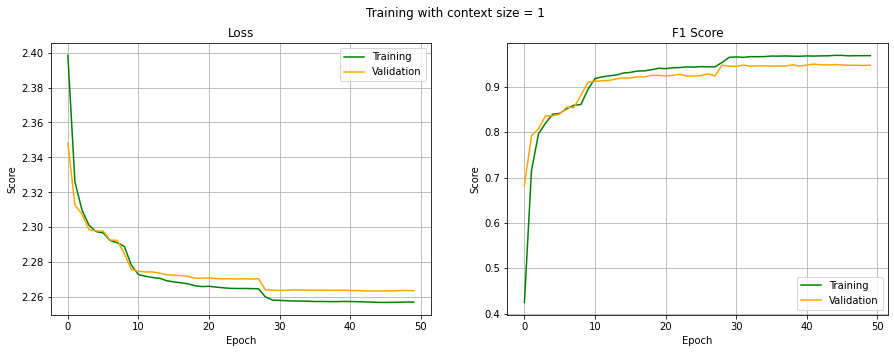

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9694, device='cuda:0'),
 tensor(0.9478, device='cuda:0'),
 tensor(0.9470, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9694, device='cuda:0'),
 tensor(0.9478, device='cuda:0'),
 tensor(0.9470, device='cuda:0'))

## Heatmap

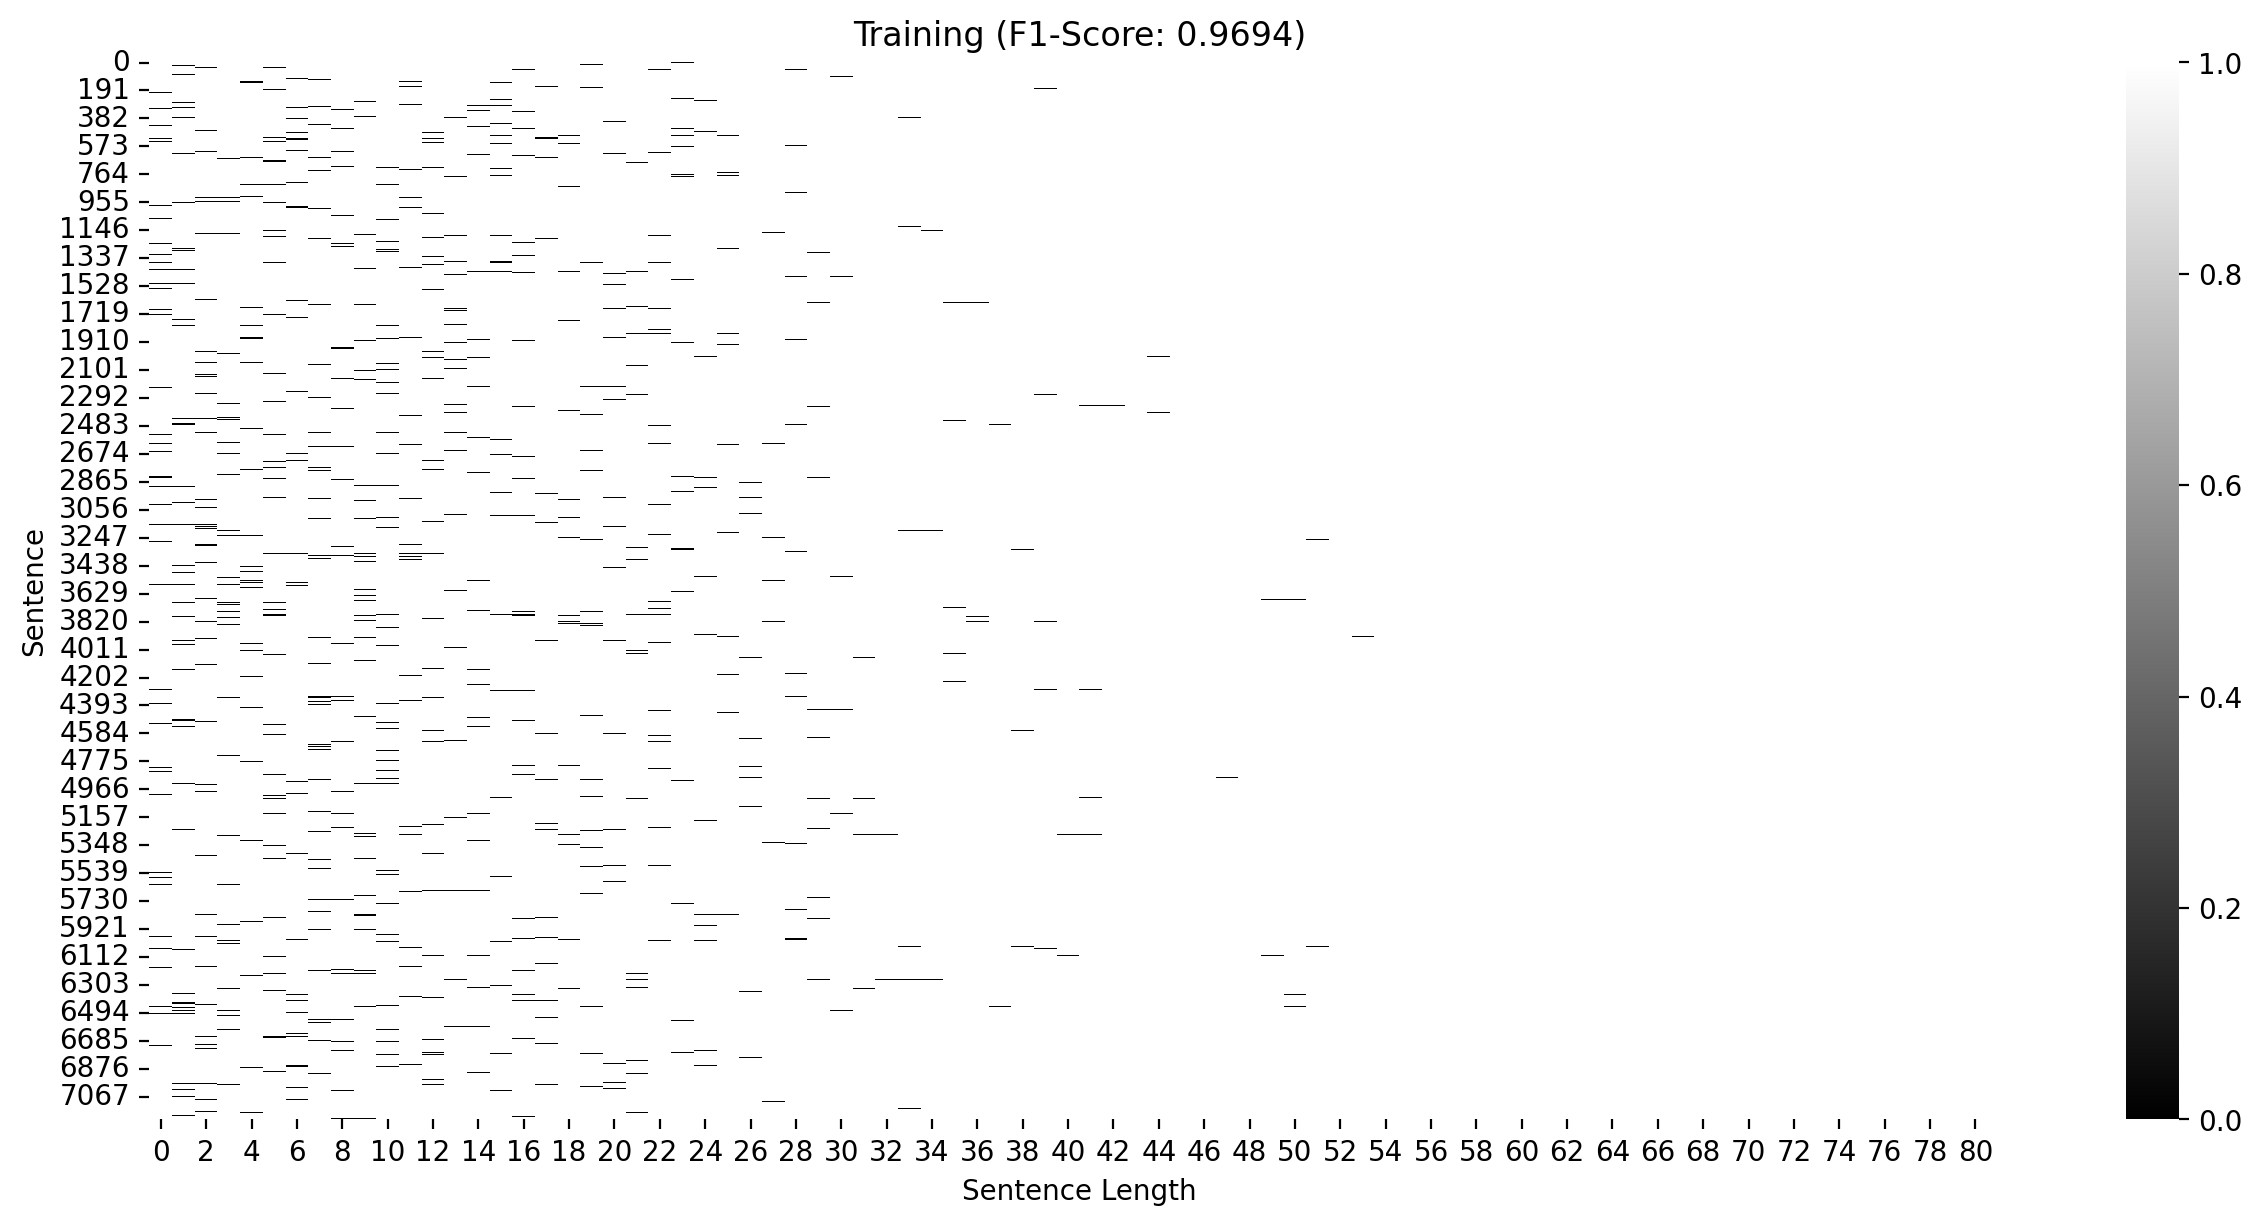

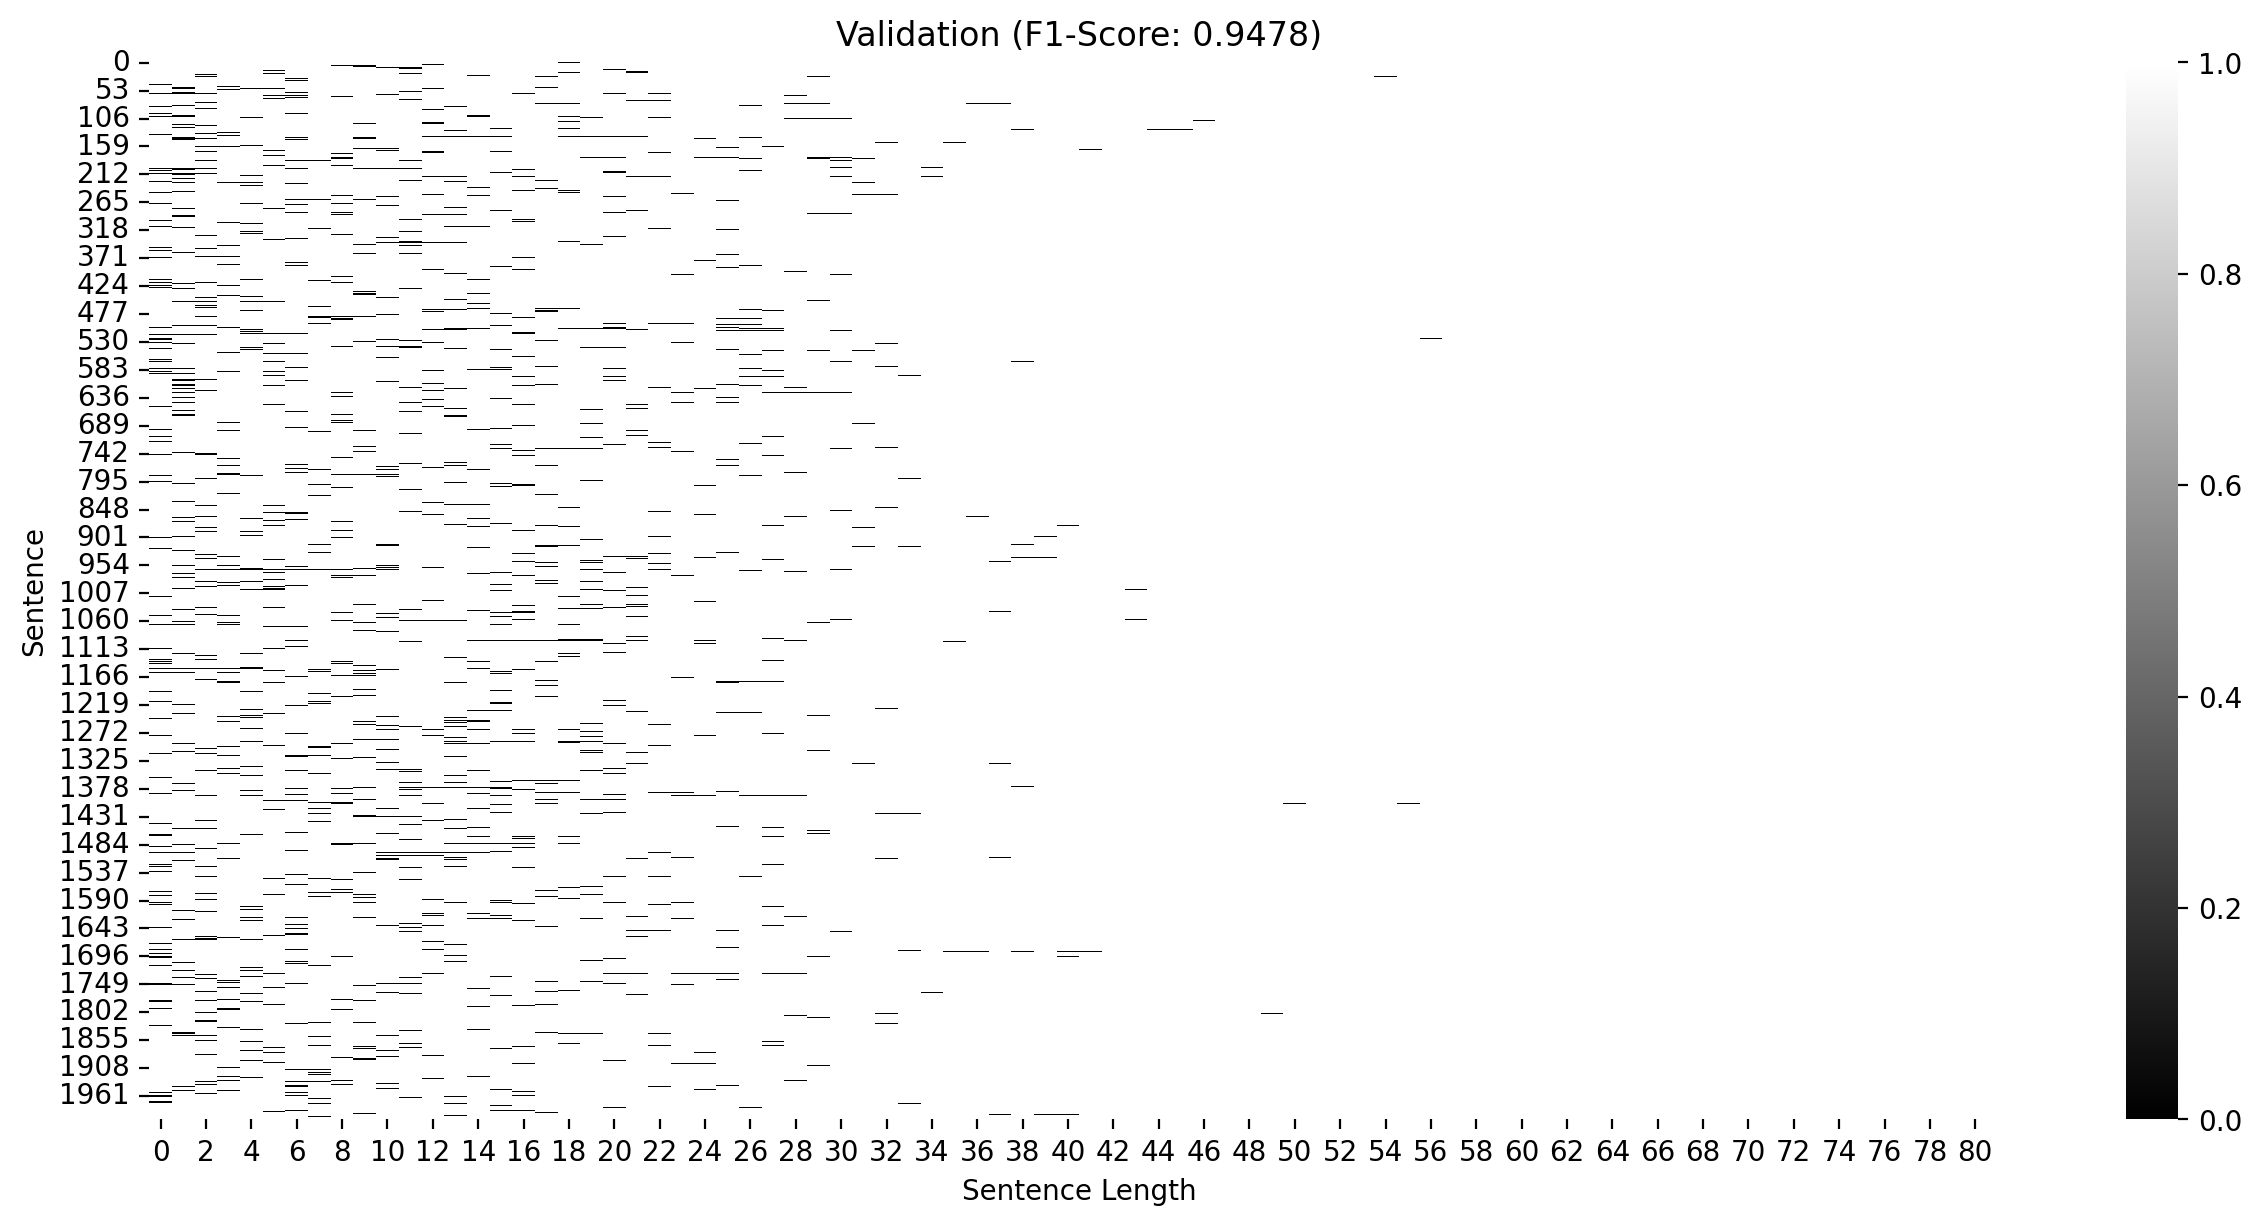

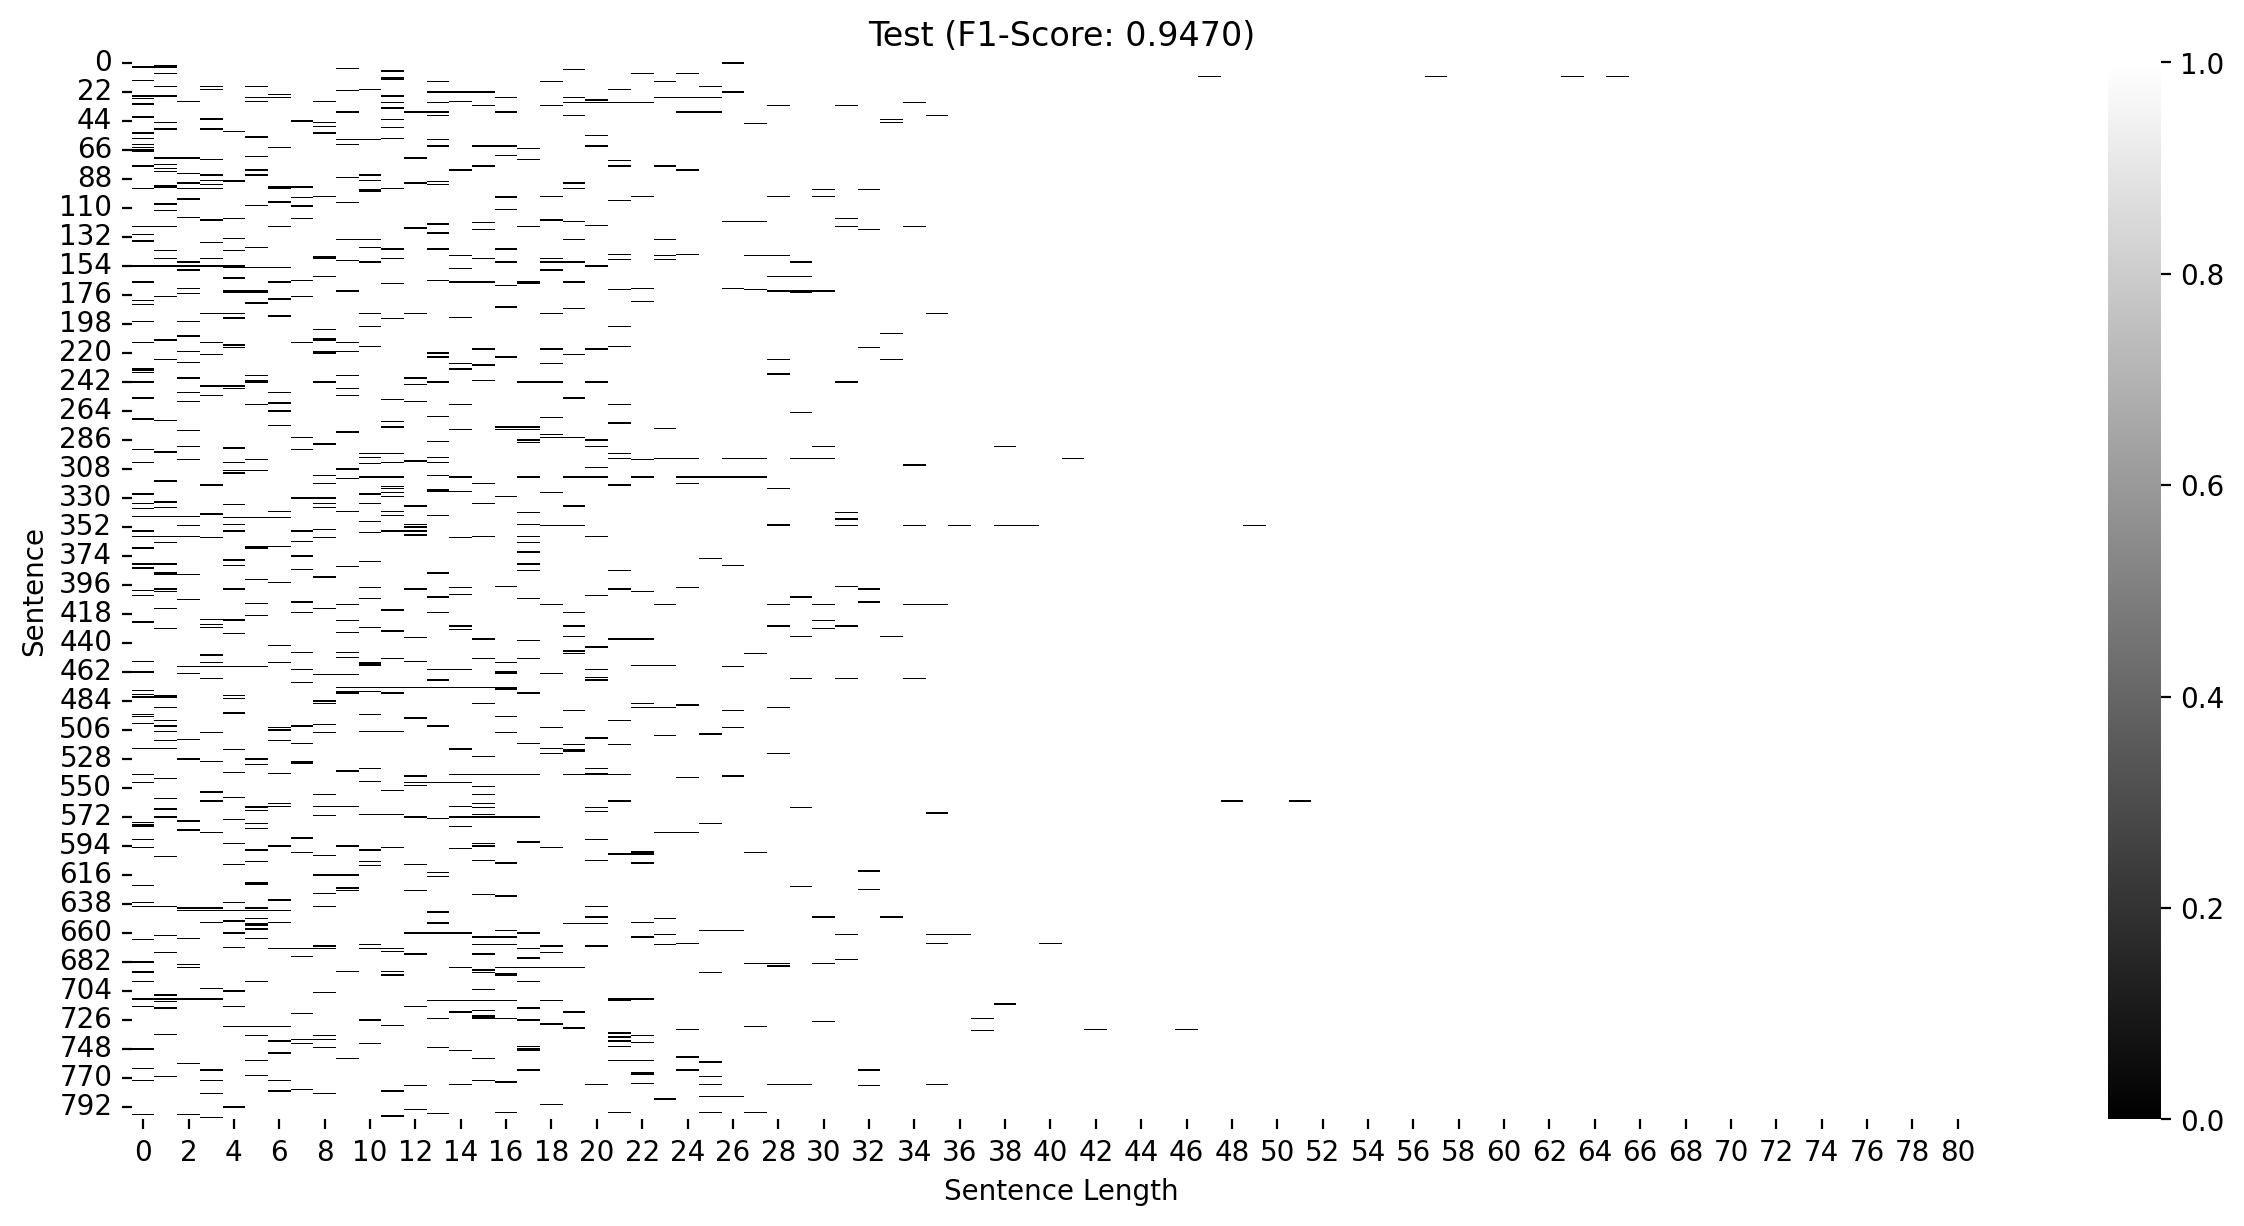

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 168 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


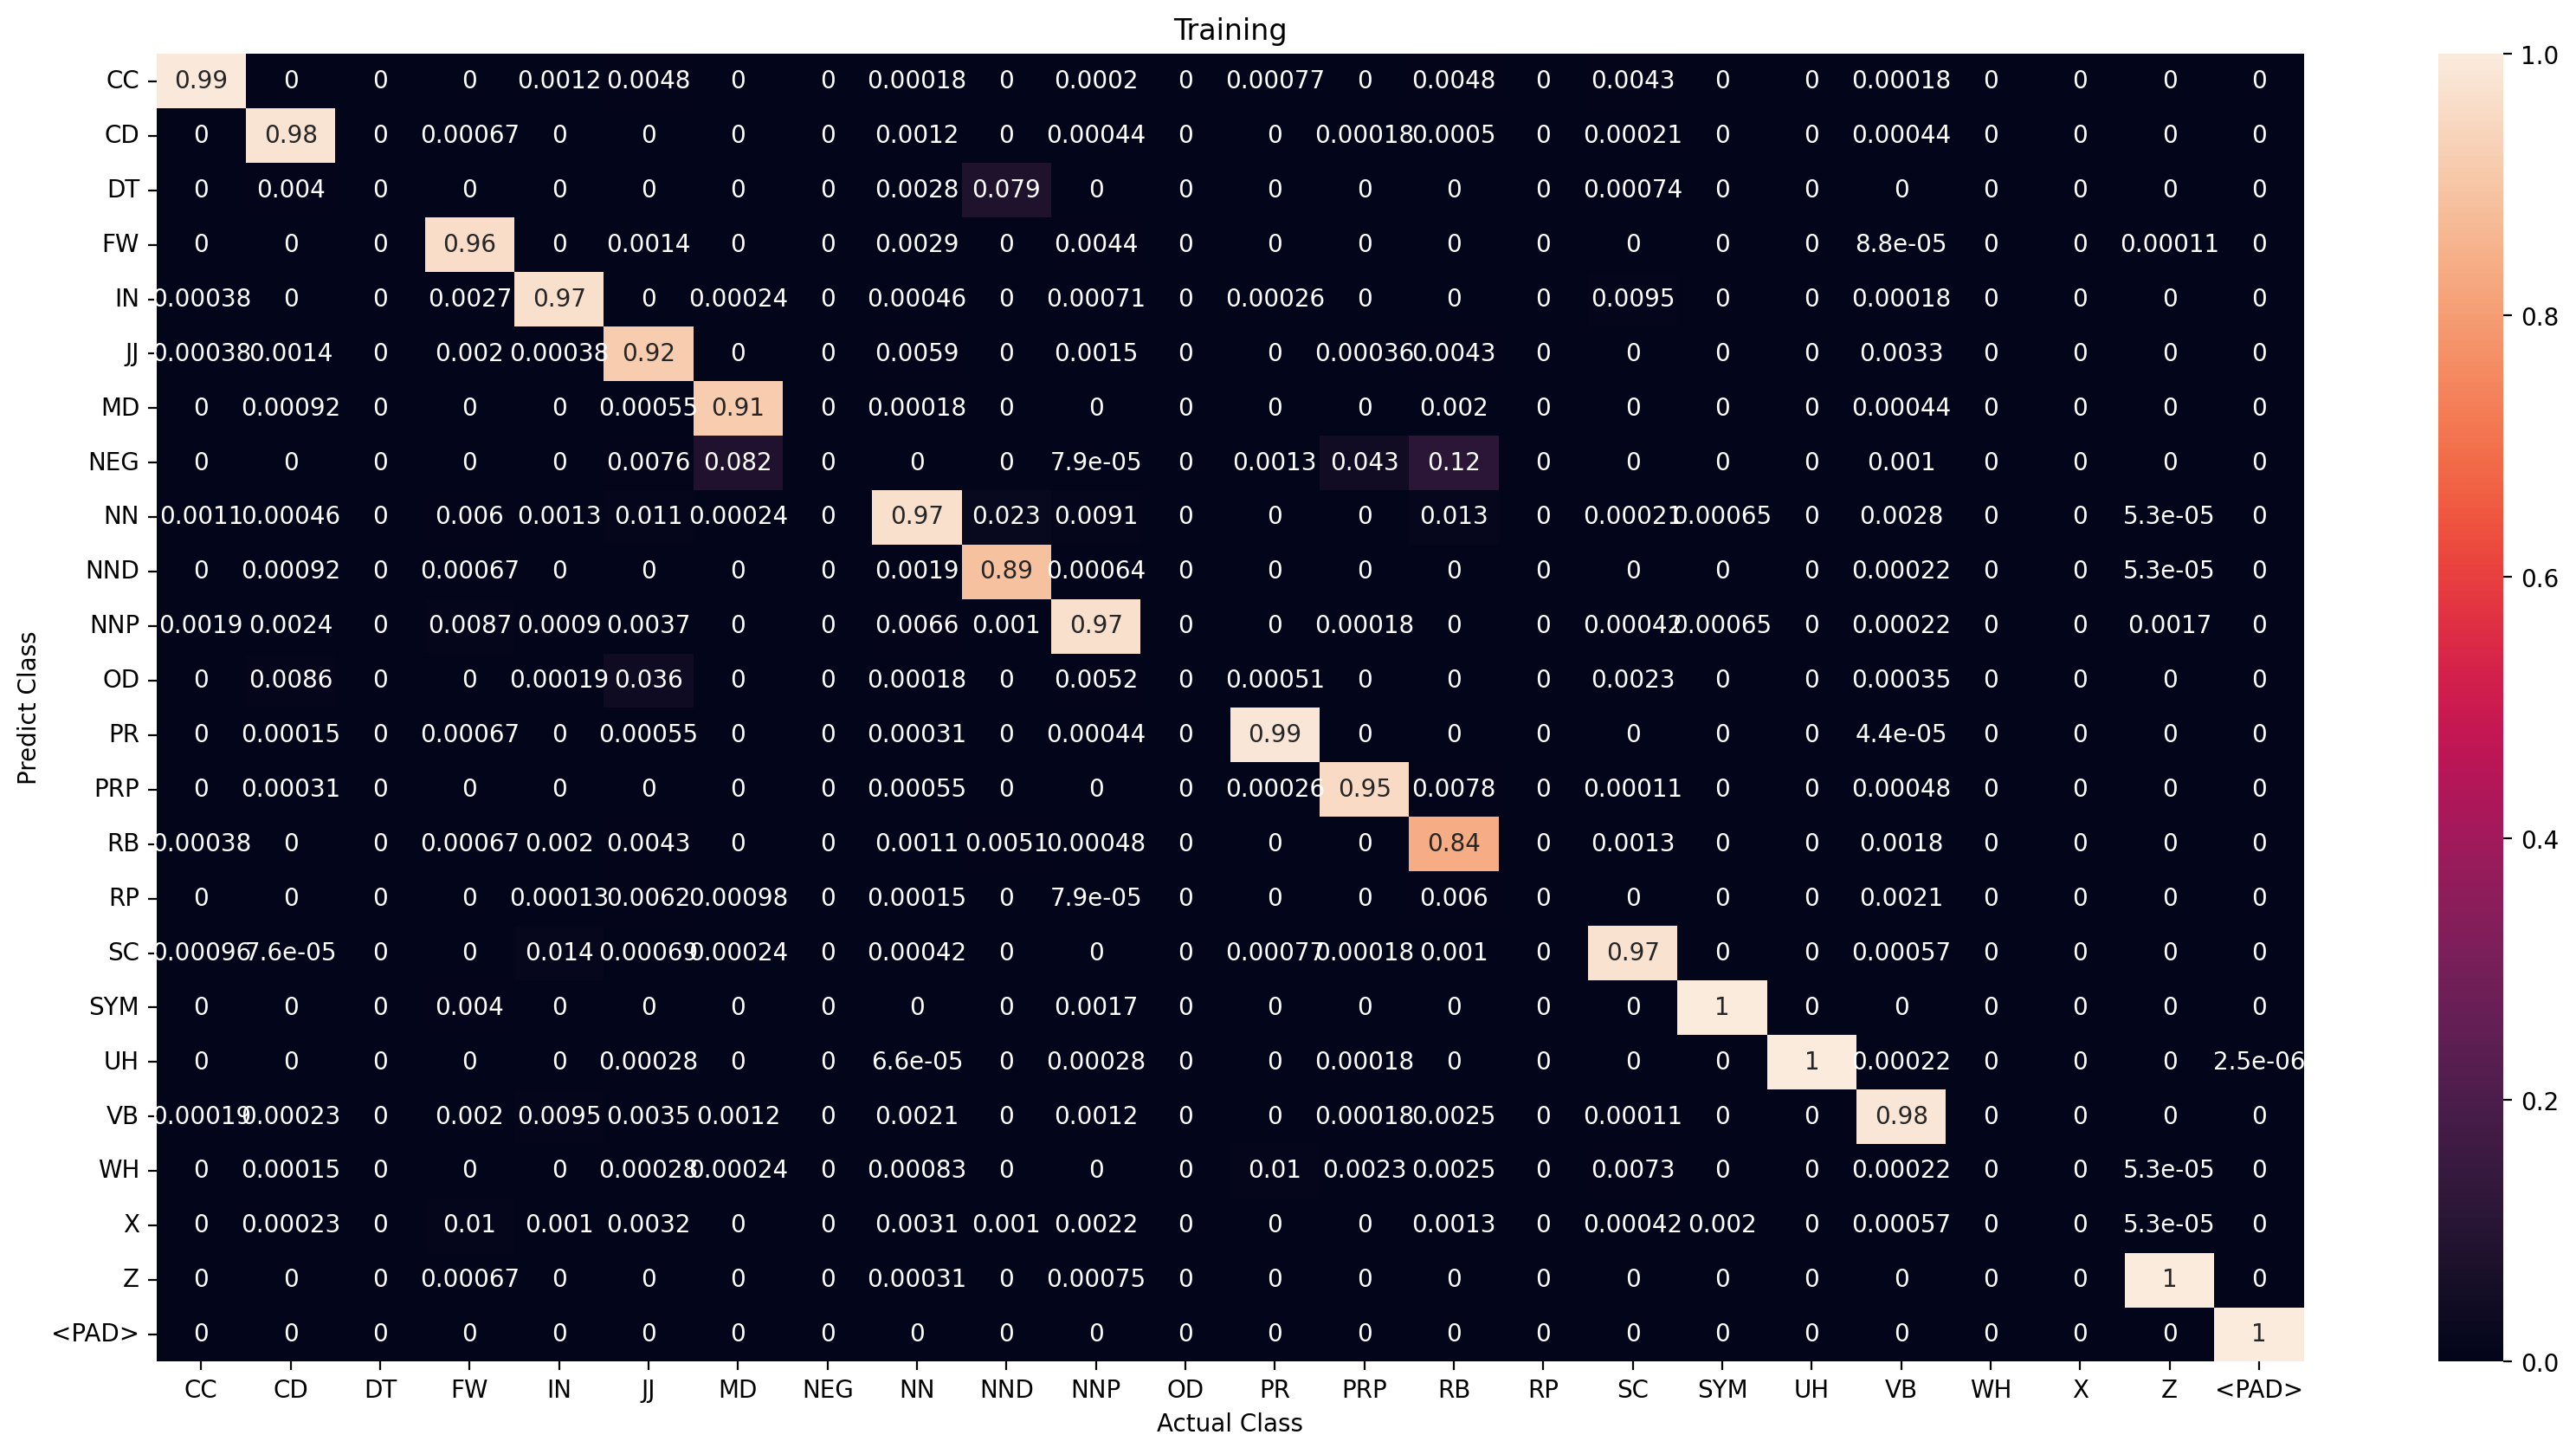

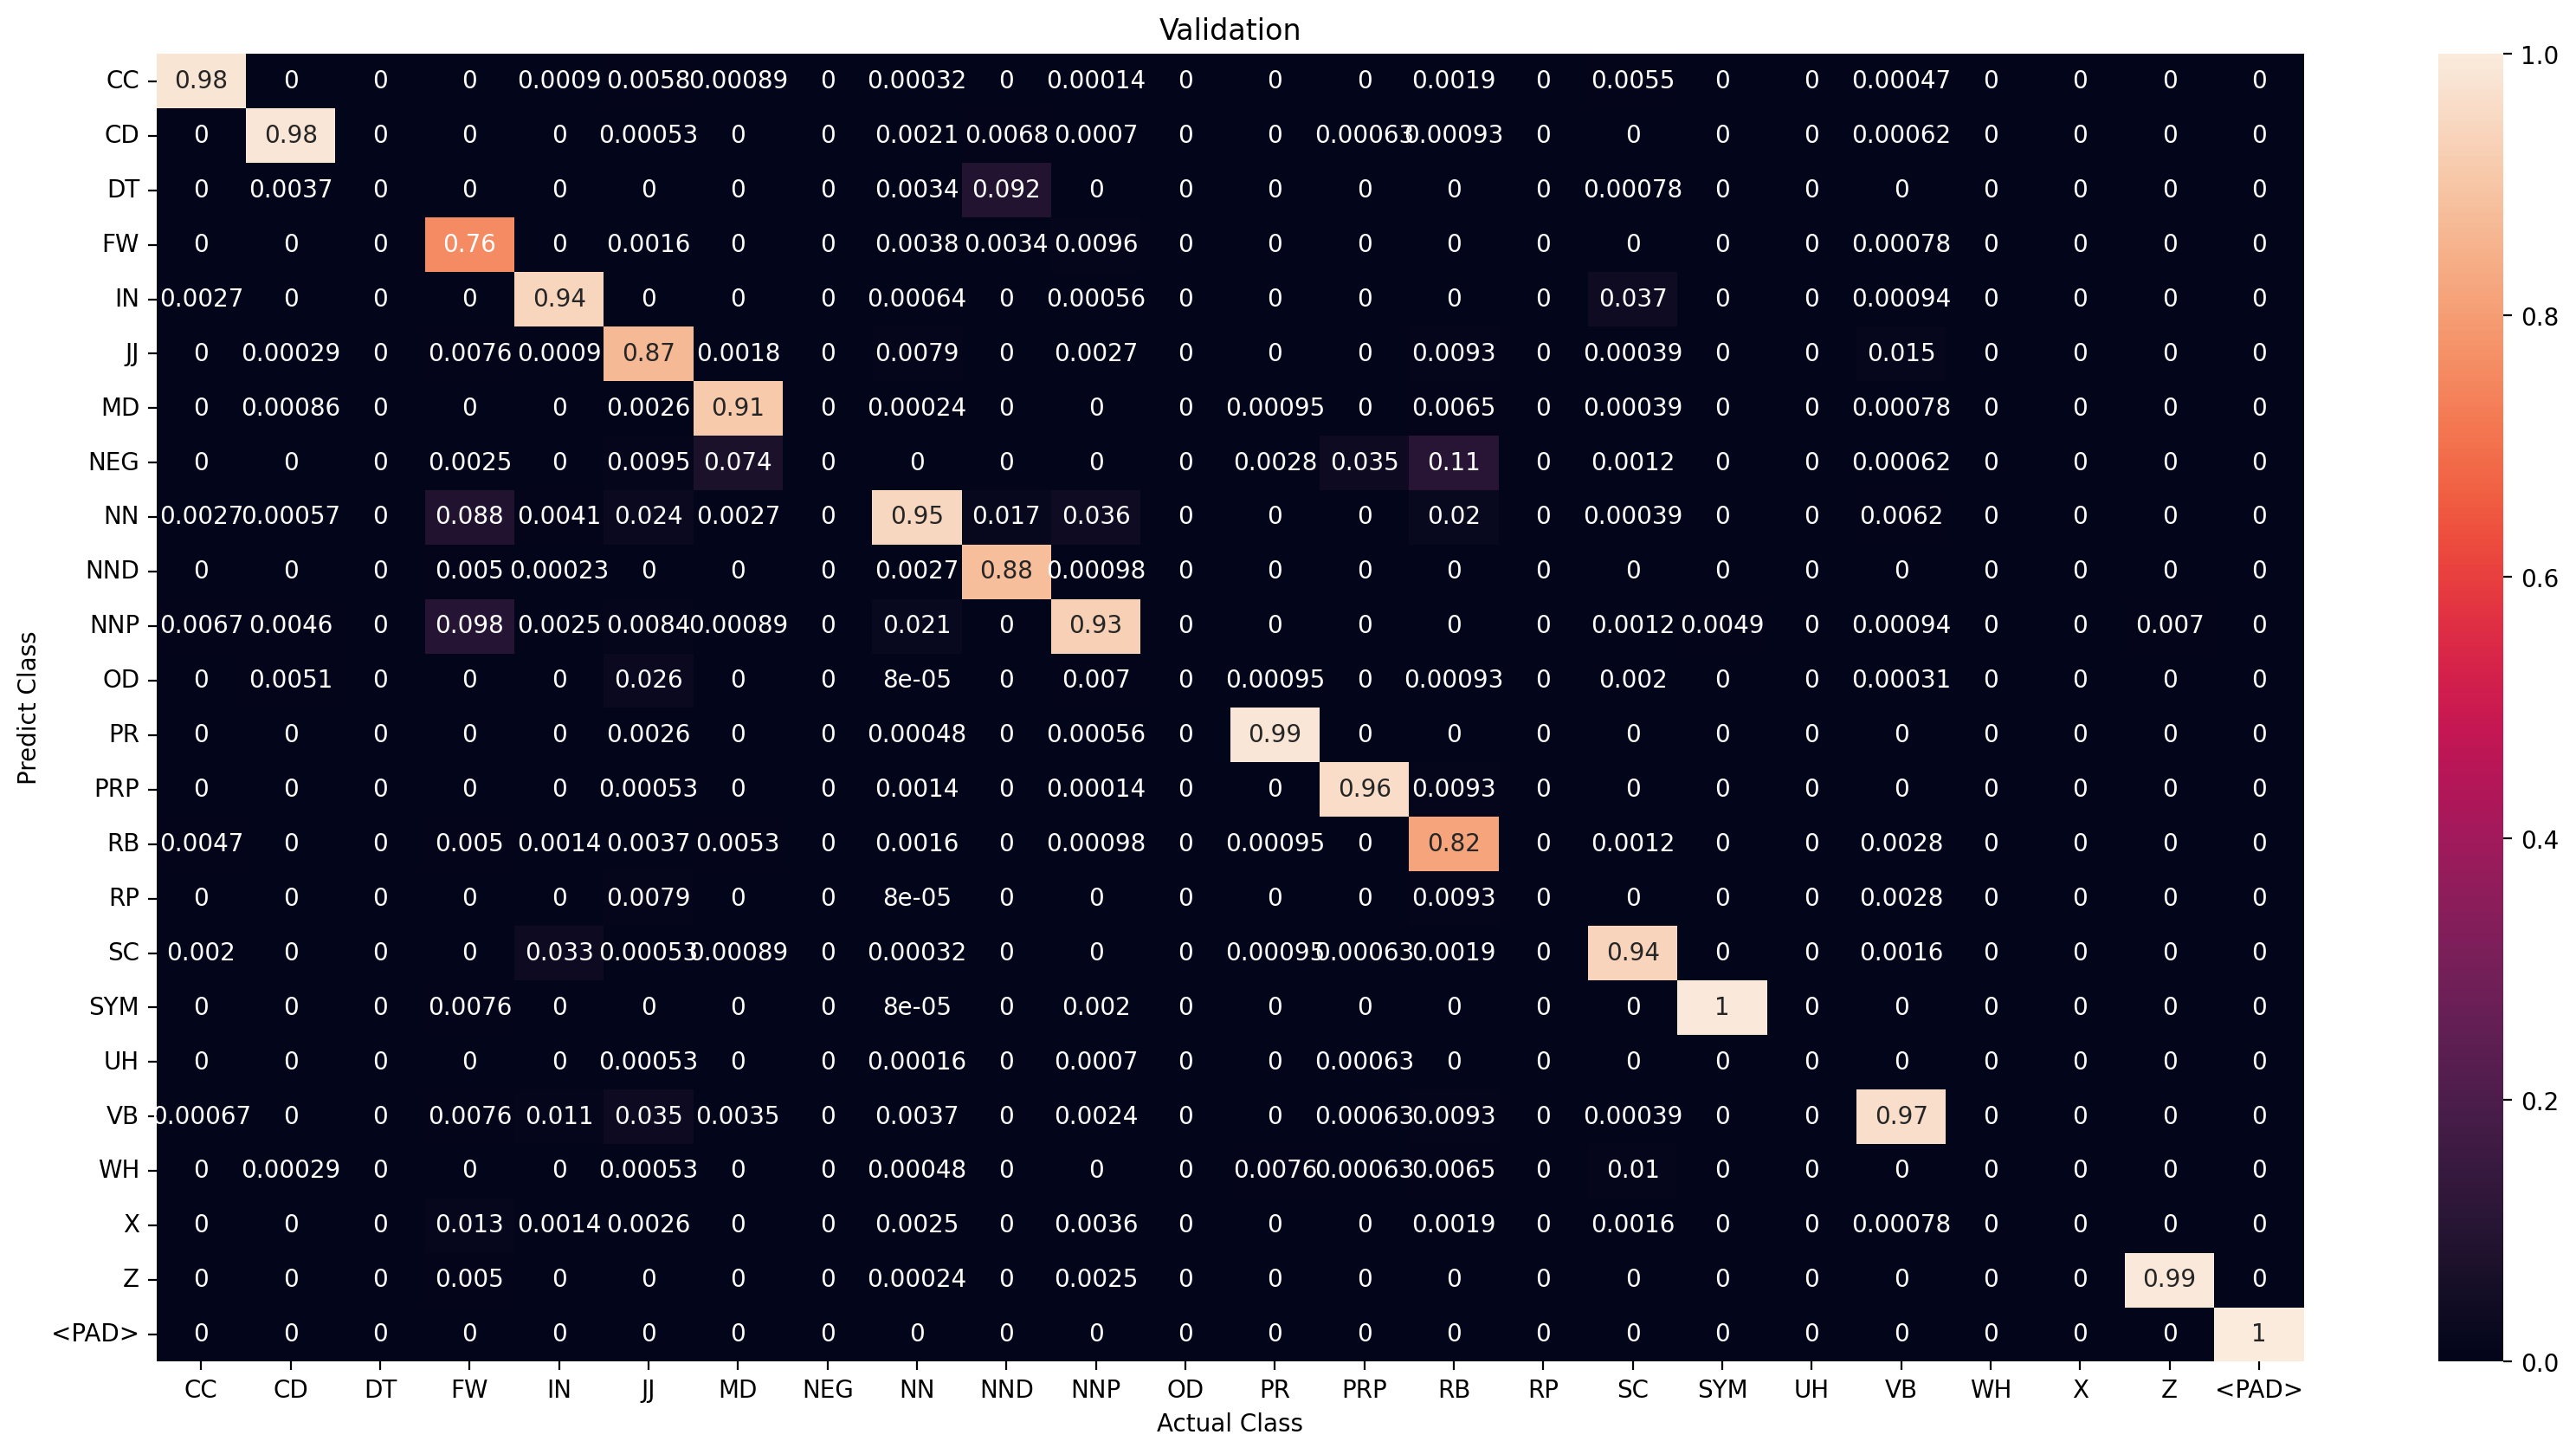

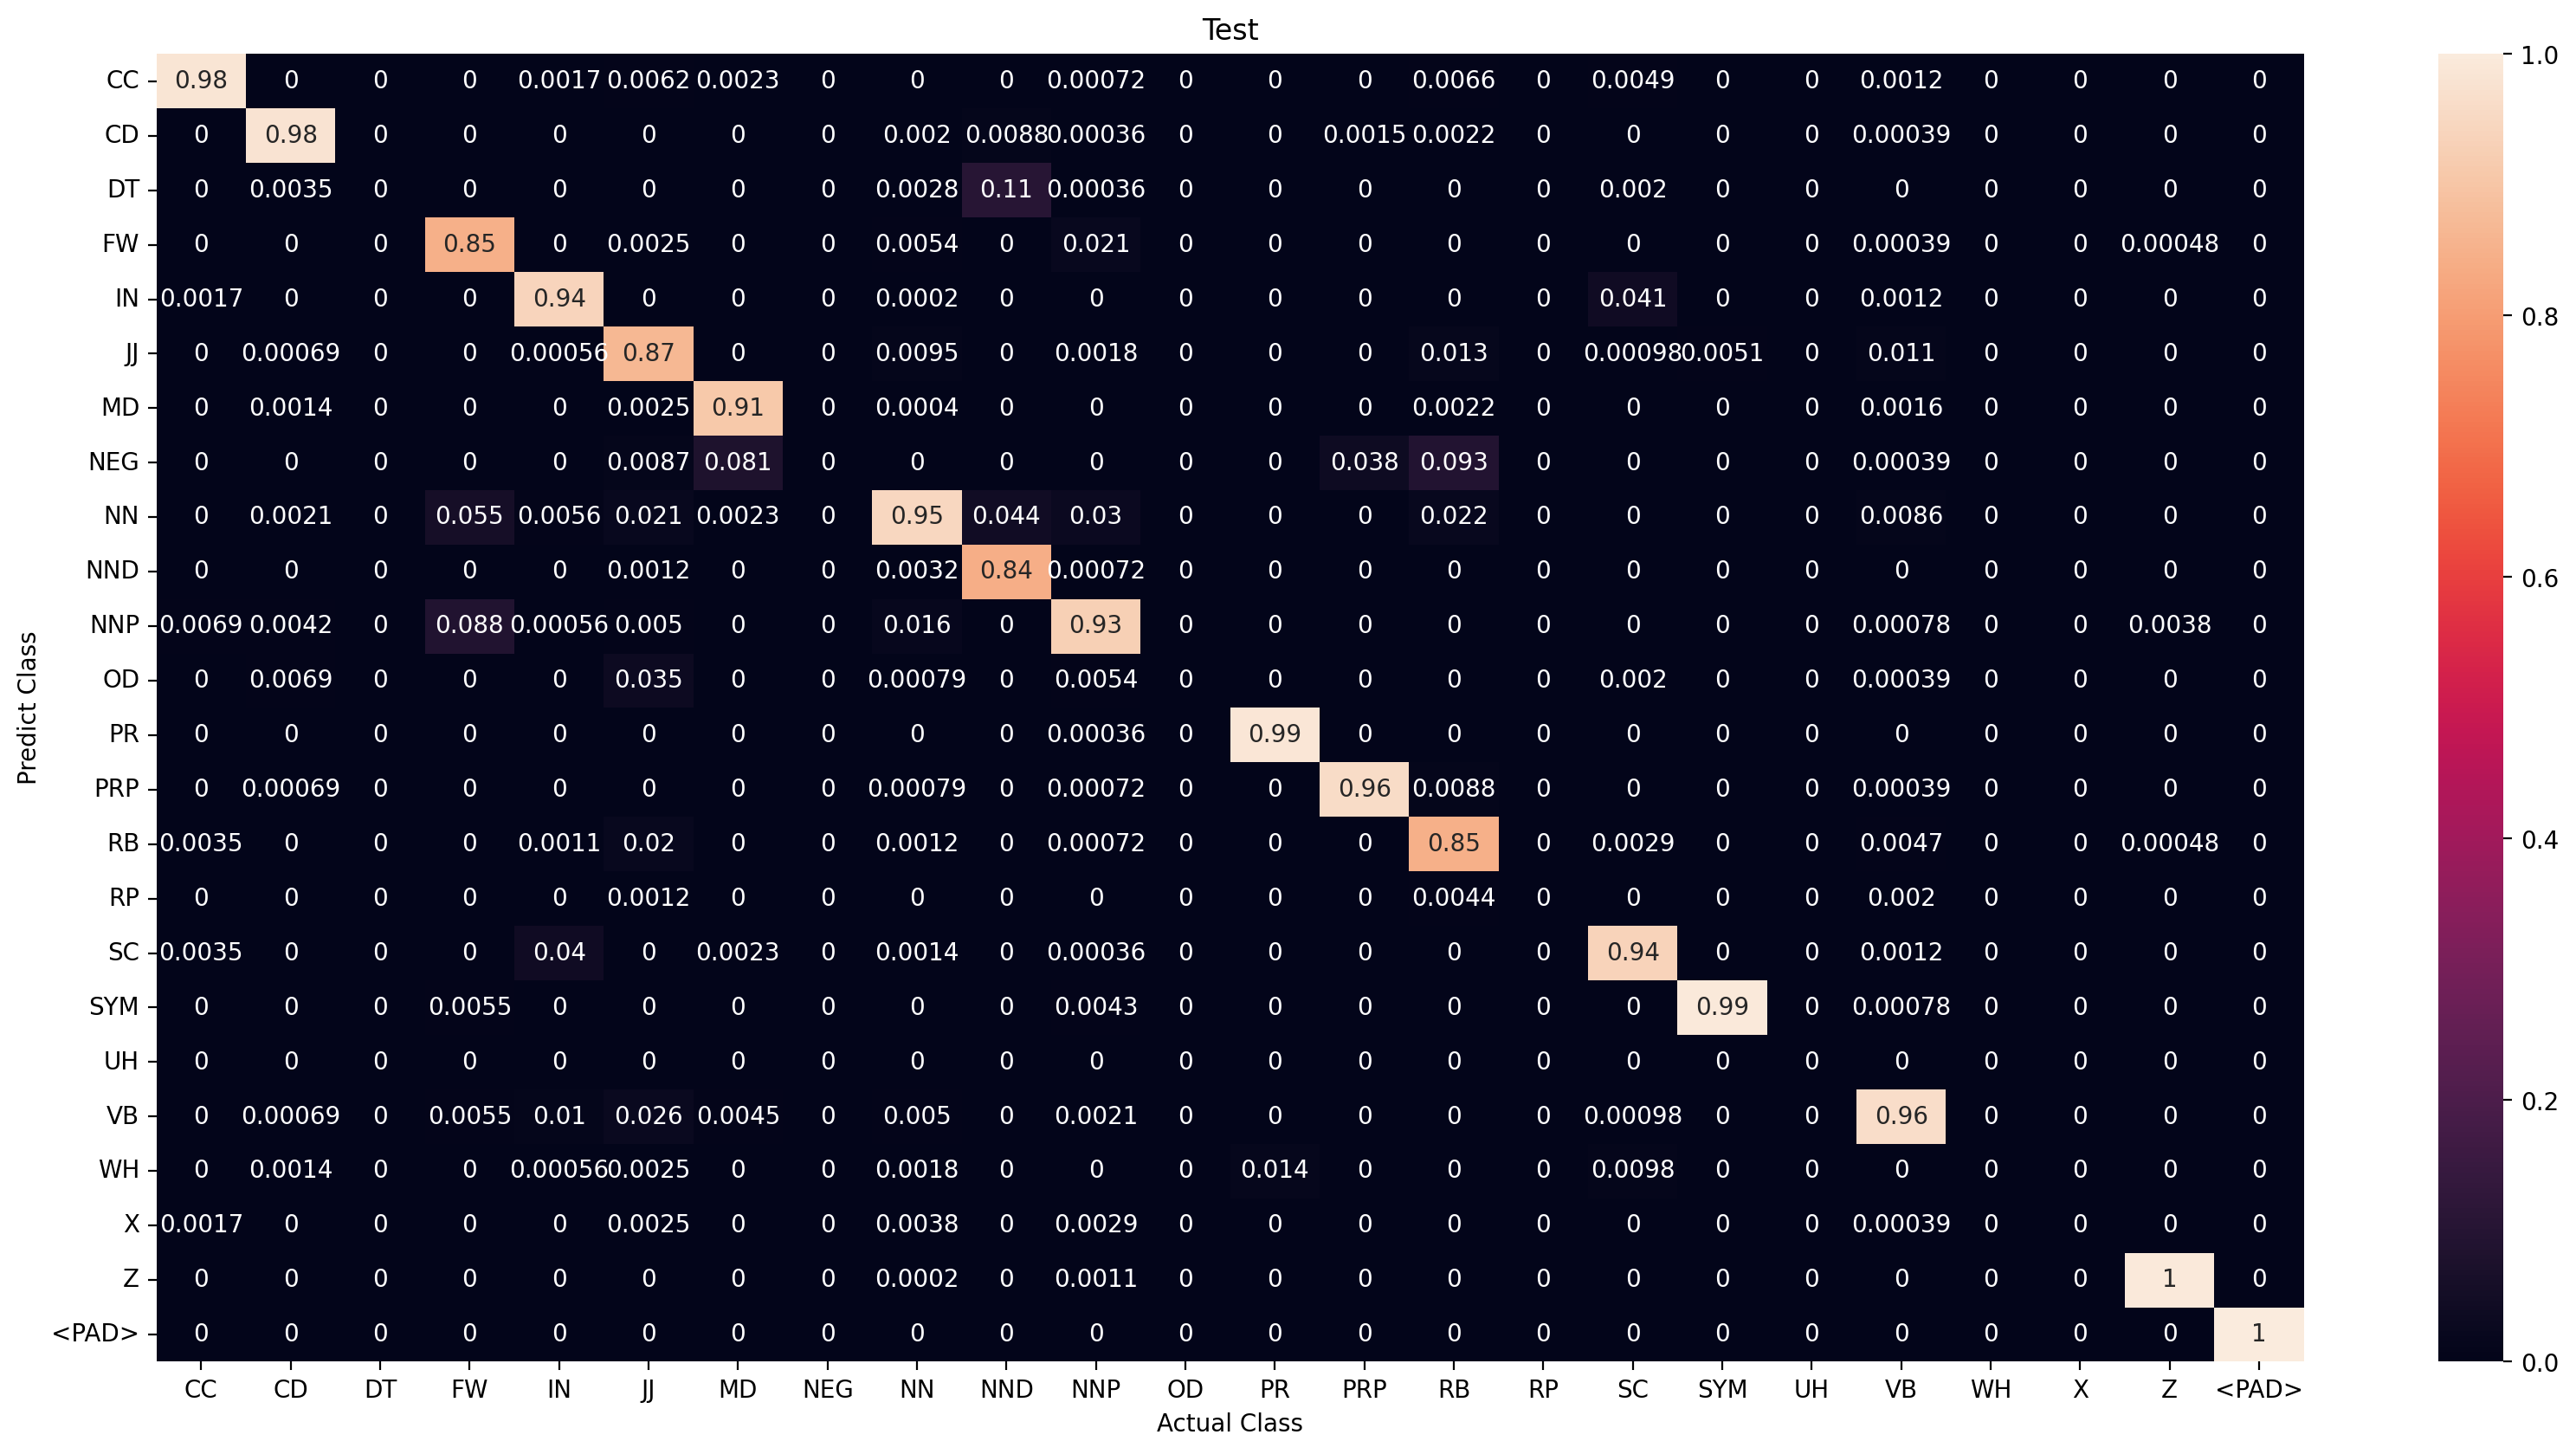

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5336   | CC    : 5203       | CC    : 133      |
| CD    : 12904  | CD    : 12820      | CD    : 84       |
| DT    : 263    | DT    : 0          | DT    : 263      |
| FW    : 1697   | FW    : 1441       | FW    : 256      |
| IN    : 15290  | IN    : 15149      | IN    : 141      |
| JJ    : 7049   | JJ    : 6620       | JJ    : 429      |
| MD    : 3783   | MD    : 3741       | MD    : 42       |
| NEG   : 1126   | NEG   : 0          | NEG   : 1126     |
| NN    : 44769  | NN    : 44272      | NN    : 497      |
| NND   : 998    | NND   : 877        | NND   : 121      |
| NNP   : 24884  | NNP   : 24441      | NNP   : 443      |
| OD    : 550    | OD    : 0          | OD    : 550      |
| PR    : 3878   | PR    : 3845       | PR    : 33       |
| PRP   : 5355   | PRP   : 5282       | PRP   : 73       |
| RB    : 3517   | RB    : 3332       | RB    : 185      |
| RP    : 131    | RP    : 0          | RP    : 131     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8,  5,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11934
Correct prediction          : 11176
Wrong prediction            : 758
Percentage correct oov pred : 93.64839953075247

Validation
Number OOV token            : 3261
Correct prediction          : 2953
Wrong prediction            : 308
Percentage correct oov pred : 90.55504446488807

Test
Number OOV token            : 1367
Correct prediction          : 1234
Wrong prediction            : 133
Percentage correct oov pred : 90.27066569129481



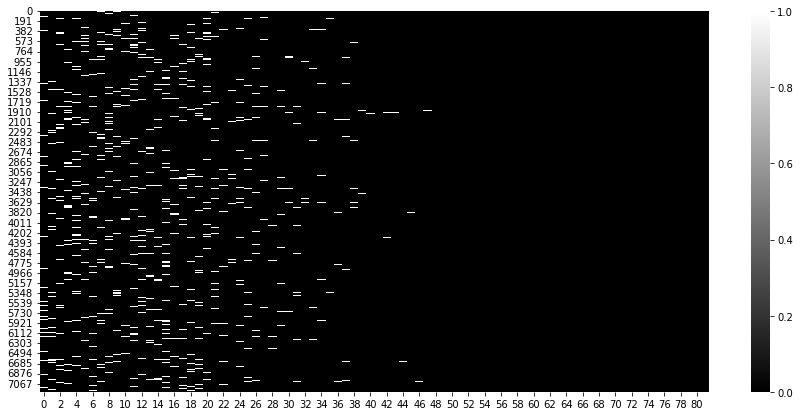

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

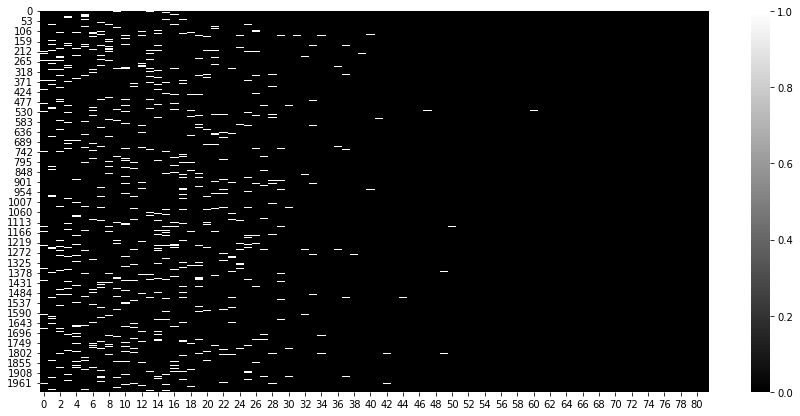

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

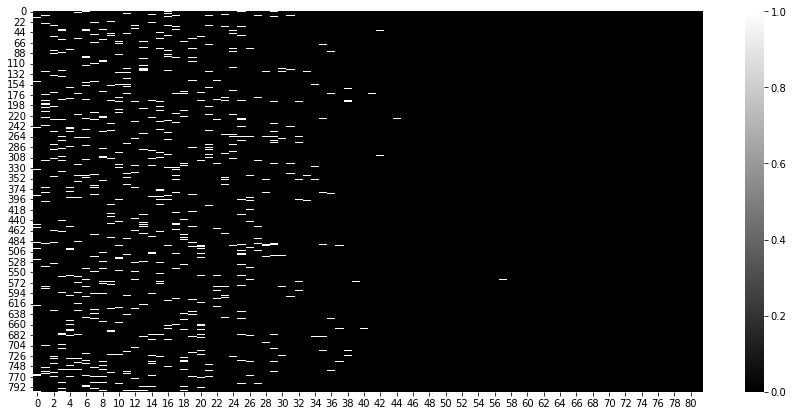

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);